# Goal

Plot the total cell counts

In [1]:
import os
from pathlib import Path
import pandas as pd
import plotnine as pn
from pypika import Query, Table, functions as fn
import cellxgene_census
from SRAgent.db.connect import db_connect

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 4)
pn.theme_set(pn.theme_bw())

In [3]:
# get base of github repo
base_dir = !git rev-parse --show-toplevel
base_dir = Path(base_dir[0])
base_dir

PosixPath('/home/nickyoungblut/dev/python/scBaseCount_analysis')

In [4]:
# add base_dir / utils.py to path
import sys
sys.path.append(str(base_dir / "scripts"))
from db_utils import get_screcounter_star_results

In [6]:
# set tenant
os.environ["DYNACONF"] = "prod"

# Load Cell x Gene census data

In [7]:
with cellxgene_census.open_soma(census_version="2025-01-30") as census:
    print(census["census_data"]["homo_sapiens"].obs.schema)

soma_joinid: int64 not null
dataset_id: dictionary<values=string, indices=int16, ordered=0>
assay: dictionary<values=string, indices=int8, ordered=0>
assay_ontology_term_id: dictionary<values=string, indices=int8, ordered=0>
cell_type: dictionary<values=string, indices=int16, ordered=0>
cell_type_ontology_term_id: dictionary<values=string, indices=int16, ordered=0>
development_stage: dictionary<values=string, indices=int16, ordered=0>
development_stage_ontology_term_id: dictionary<values=string, indices=int16, ordered=0>
disease: dictionary<values=string, indices=int16, ordered=0>
disease_ontology_term_id: dictionary<values=string, indices=int16, ordered=0>
donor_id: dictionary<values=string, indices=int16, ordered=0>
is_primary_data: bool
observation_joinid: large_string
self_reported_ethnicity: dictionary<values=string, indices=int8, ordered=0>
self_reported_ethnicity_ontology_term_id: dictionary<values=string, indices=int8, ordered=0>
sex: dictionary<values=string, indices=int8, ord

In [8]:
# filter human datasets to targets with cell counts
cxg_data = []
organisms = ["homo_sapiens", "mus_musculus"]
with cellxgene_census.open_soma(census_version="2025-01-30") as census:
    for organism in organisms:
        df = (
            census["census_data"][organism]
            .obs.read(column_names=["tissue", "tissue_general", "tissue_ontology_term_id", "dataset_id"])
            .concat()
            .group_by(["tissue", "tissue_general", "tissue_ontology_term_id", "dataset_id"])
            .aggregate([([], "count_all")])  # Count all rows per group
            .to_pandas() 
        )
        # Rename the count column to something more meaningful
        df = df.rename(columns={"count_all": "cell_count"})
        df["organism"] = organism
        cxg_data.append(df)
cxg_data = pd.concat(cxg_data)
cxg_data

,tissue,tissue_general,tissue_ontology_term_id,dataset_id,cell_count,organism
0,liver,liver,UBERON:0002107,d7476ae2-e320-4703-8304-da5c42627e71,565,homo_sapiens
1,caudate lobe of liver,liver,UBERON:0001117,0895c838-e550-48a3-a777-dbcd35d30272,146,homo_sapiens
...,...,...,...,...,...,...
311,embryo,embryo,UBERON:0000922,dcfa2614-7ca7-4d82-814c-350626eccb26,3267338,mus_musculus
312,embryo,embryo,UBERON:0000922,dcfd4feb-18a3-4b30-81d7-1b0c544a8ab3,11441407,mus_musculus


In [9]:
# rename organism "homo_sapiens" => "Homo sapiens", "mus_musculus" => "Mus musculus"
cxg_data["organism"] = cxg_data["organism"].replace({"homo_sapiens": "Homo sapiens", "mus_musculus": "Mus musculus"})
cxg_data

,tissue,tissue_general,tissue_ontology_term_id,dataset_id,cell_count,organism
0,liver,liver,UBERON:0002107,d7476ae2-e320-4703-8304-da5c42627e71,565,Homo sapiens
1,caudate lobe of liver,liver,UBERON:0001117,0895c838-e550-48a3-a777-dbcd35d30272,146,Homo sapiens
...,...,...,...,...,...,...
311,embryo,embryo,UBERON:0000922,dcfa2614-7ca7-4d82-814c-350626eccb26,3267338,Mus musculus
312,embryo,embryo,UBERON:0000922,dcfd4feb-18a3-4b30-81d7-1b0c544a8ab3,11441407,Mus musculus


In [10]:
# summarize counts by organism
cxg_data_organism = (
    cxg_data.groupby(["organism"])
    .agg({"cell_count": "sum"})
)
cxg_data_organism

,cell_count
organism,
Homo sapiens,106118167
Mus musculus,42776863


# Load scBaseCount

In [11]:
# get the screcounter_star_results table
with db_connect() as conn:
    df_cells = get_screcounter_star_results(conn, feature="GeneFull_Ex50pAS")
df_cells

,srx_accession,feature,estimated_number_of_cells,median_reads_per_cell,median_umi_per_cell,median_feature_per_cell,umis_in_cells,lib_prep,tech_10x,organism,tissue,tissue_ontology_term_id,cell_prep
0,SRX22482811,GeneFull_Ex50pAS,4155,1558.0,985.0,677.0,5375698,10x_Genomics,5_prime_gex,Homo sapiens,blood,UBERON:0000178,single_cell
1,SRX13824065,GeneFull_Ex50pAS,6348,20669.0,2371.0,1288.0,17168948,10x_Genomics,3_prime_gex,Mus musculus,skin,UBERON:0022295,single_cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61575,NRX0000392,GeneFull_Ex50pAS,12342,9227.0,5112.0,2778.0,97678450,10x_Genomics,3_prime_gex,Callithrix jacchus,brain,UBERON:0000955,single_nucleus
61576,NRX0000393,GeneFull_Ex50pAS,6180,640.0,492.0,425.0,3672087,10x_Genomics,3_prime_gex,Callithrix jacchus,brain,UBERON:0000955,single_nucleus


In [12]:
# total cell counts (millions)
df_cells["estimated_number_of_cells"].sum() / 1e6

503.021899

In [13]:
# load CellxGene tissue categories
df_tissue_cats = pd.read_csv(base_dir / "data" / "tissues" / "2025-06-30_tissue_categories.csv.gz")
df_tissue_cats

,tissue,category
0,2 layer spheroid,other
1,"3 layer spheroid channel 1,epithelial",other
...,...,...
15543,zebrafish larval intestines,intestine
15544,zebrafish marrow,bone marrow


In [14]:
# left join on tissue
df_cells = df_cells.merge(df_tissue_cats, on="tissue", how="left")
df_cells["category"] = df_cells["category"].apply(lambda x: "other" if pd.isna(x) else x)
df_cells

,srx_accession,feature,estimated_number_of_cells,median_reads_per_cell,median_umi_per_cell,median_feature_per_cell,umis_in_cells,lib_prep,tech_10x,organism,tissue,tissue_ontology_term_id,cell_prep,category
0,SRX22482811,GeneFull_Ex50pAS,4155,1558.0,985.0,677.0,5375698,10x_Genomics,5_prime_gex,Homo sapiens,blood,UBERON:0000178,single_cell,blood
1,SRX13824065,GeneFull_Ex50pAS,6348,20669.0,2371.0,1288.0,17168948,10x_Genomics,3_prime_gex,Mus musculus,skin,UBERON:0022295,single_cell,skin of body
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61575,NRX0000392,GeneFull_Ex50pAS,12342,9227.0,5112.0,2778.0,97678450,10x_Genomics,3_prime_gex,Callithrix jacchus,brain,UBERON:0000955,single_nucleus,brain
61576,NRX0000393,GeneFull_Ex50pAS,6180,640.0,492.0,425.0,3672087,10x_Genomics,3_prime_gex,Callithrix jacchus,brain,UBERON:0000955,single_nucleus,brain


# Cell counts by tissue

In [15]:
# set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# count cells by organism
df_cells["organism"].value_counts()

organism
Homo sapiens               35426
Mus musculus               21475
Macaca mulatta              1275
Danio rerio                  842
Drosophila melanogaster      416
Callithrix jacchus           406
Sus scrofa                   317
Rattus norvegicus            271
Arabidopsis thaliana         232
Bos taurus                   176
Gallus gallus                146
Heterocephalus glaber        133
Ovis aries                   112
Pan troglodytes               72
Caenorhabditis elegans        58
Mesocricetus auratus          46
Oryctolagus cuniculus         38
Zea mays                      35
Oryza sativa                  35
Chlorocebus aethiops          20
Equus caballus                13
Solanum lycopersicum          10
Schistosoma mansoni            9
Monodelphis domestica          6
Gasterosteus aculeatus         5
Gorilla gorilla                2
Taeniopygia guttata            1
Name: count, dtype: int64

In [63]:
pd.set_option('display.max_rows', 4)

In [64]:
# filter to mammals
mammals = [
    "Homo sapiens",           # Human
    "Mus musculus",           # House mouse
    "Macaca mulatta",         # Rhesus macaque
    "Sus scrofa",             # Wild boar/domestic pig
    "Rattus norvegicus",      # Brown rat
    "Bos taurus",             # Cattle
    "Callithrix jacchus",     # Common marmoset
    "Heterocephalus glaber",  # Naked mole-rat
    "Ovis aries",             # Sheep
    "Pan troglodytes",        # Chimpanzee
    "Mesocricetus auratus",   # Golden hamster
    "Oryctolagus cuniculus",  # European rabbit
    "Chlorocebus aethiops",   # Grivet monkey
    "Equus caballus",         # Horse
    "Monodelphis domestica",  # Gray short-tailed opossum
    "Gorilla gorilla"         # Gorilla
]
len(mammals)

16

In [65]:
# group by category and summarize cell counts
df_cells_tissues = (
    df_cells[df_cells["organism"].isin(mammals)]
    .groupby("category")
    .agg({"estimated_number_of_cells": "sum"})
    .reset_index()
    .rename(columns={"estimated_number_of_cells": "cell_count", "category": "tissue"})
)
df_cells_tissues["dataset"] = "scBaseCount"
df_cells_tissues

,tissue,cell_count,dataset
0,abdomen,368827,scBaseCount
1,adipose tissue,3335357,scBaseCount
...,...,...,...
66,vasculature,6445374,scBaseCount
67,yolk sac,182268,scBaseCount


In [66]:
# group by tissue and summarize cell counts
cxg_data_tissues = (
    cxg_data.groupby(["tissue_general"])
    .agg({"cell_count": "sum"})
    .reset_index()
    .rename(columns={"tissue_general": "tissue"})
)
cxg_data_tissues["dataset"] = "CZ CELLxGENE"
cxg_data_tissues

,tissue,cell_count,dataset
0,abdomen,414553,CZ CELLxGENE
1,adipose tissue,1515281,CZ CELLxGENE
...,...,...,...
68,vasculature,434699,CZ CELLxGENE
69,yolk sac,169725,CZ CELLxGENE


In [67]:
# combine the two datasets
df_all_tissues = pd.concat([df_cells_tissues, cxg_data_tissues])

# filter out "other" tissue
df_all_tissues = df_all_tissues[df_all_tissues["tissue"] != "other"]

# results
df_all_tissues

,tissue,cell_count,dataset
0,abdomen,368827,scBaseCount
1,adipose tissue,3335357,scBaseCount
...,...,...,...
68,vasculature,434699,CZ CELLxGENE
69,yolk sac,169725,CZ CELLxGENE


In [68]:
# filter to top 30 tissues
top_n = df_all_tissues.sort_values('cell_count', ascending=False)["tissue"].unique()[:30]
df_all_tissues_f = df_all_tissues[df_all_tissues["tissue"].isin(top_n)]
# format cell count as millions
df_all_tissues_f["cell_count"] = df_all_tissues_f["cell_count"] / 1e6
df_all_tissues_f

/tmp/ipykernel_4146093/2456847328.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,tissue,cell_count,dataset
1,adipose tissue,3.335357,scBaseCount
4,blood,79.648774,scBaseCount
...,...,...,...
67,uterus,0.587562,CZ CELLxGENE
68,vasculature,0.434699,CZ CELLxGENE


/tmp/ipykernel_4146093/34756486.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


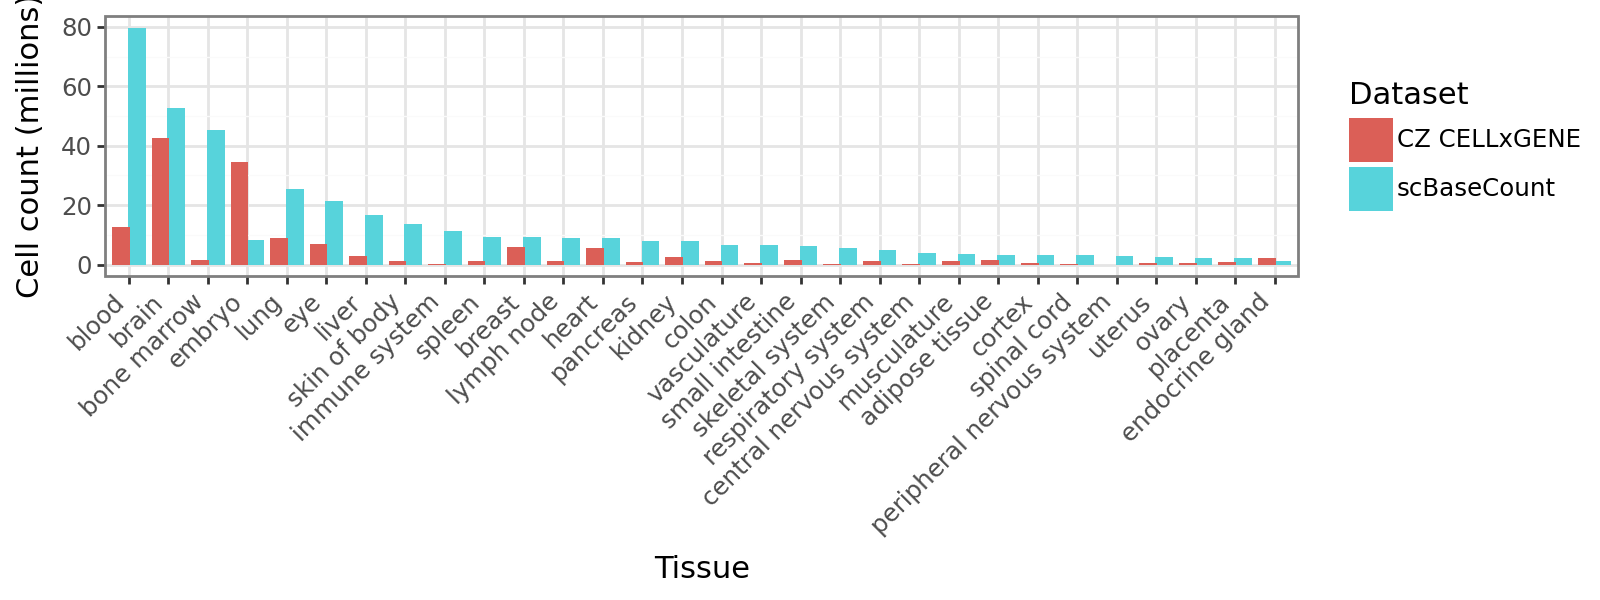

In [69]:
# plot cells per organism

## sort tissue by cell count
df_all_tissues_f['tissue'] = pd.Categorical(
    df_all_tissues_f['tissue'], 
    categories=df_all_tissues_f.sort_values('cell_count', ascending=False)['tissue'].unique().tolist(), 
    ordered=True
)

## plot
p = (
    pn.ggplot(df_all_tissues_f, pn.aes(x="tissue", y="cell_count", fill="dataset")) + 
    pn.geom_col(position=pn.position_dodge(width=0.8)) +
    pn.labs(x="Tissue", y="Cell count (millions)", fill="Dataset") +
    pn.theme(
        figure_size=(8,3),
        axis_text_x=pn.element_text(angle=45, hjust=1)
    ))
p

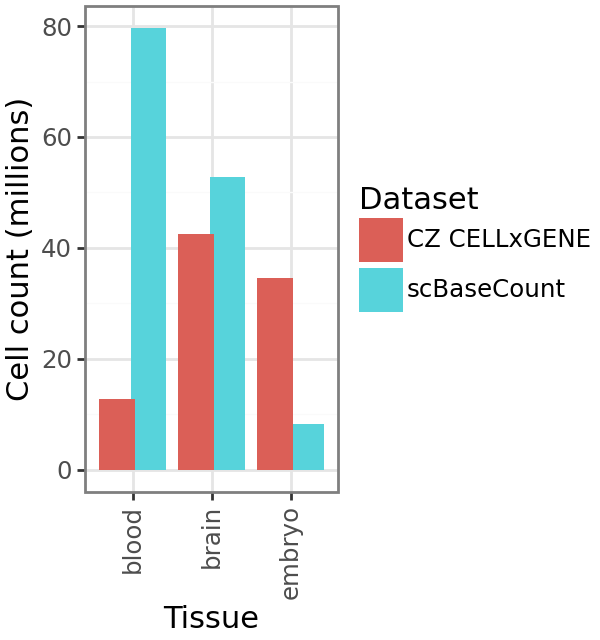

In [70]:
target_cols = ["brain", "blood", "embryo"]
## plot
p = (
    pn.ggplot(
        df_all_tissues_f[df_all_tissues_f["tissue"].isin(target_cols)],
        pn.aes(x="tissue", y="cell_count", fill="dataset")
    ) + 
    pn.geom_col(position=pn.position_dodge(width=0.8)) +
    pn.labs(x="Tissue", y="Cell count (millions)", fill="Dataset") +
    pn.theme(
        figure_size=(3,3.2),
        axis_text_x=pn.element_text(angle=90, hjust=0.98)
    ))
p

In [71]:
# save as svg
outfile = base_dir / "figures" / "scBC-CxG_cells-by-tissue_top3.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/scBC-CxG_cells-by-tissue_top3.svg


/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 3 x 3.2 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/scBC-CxG_cells-by-tissue_top3.svg


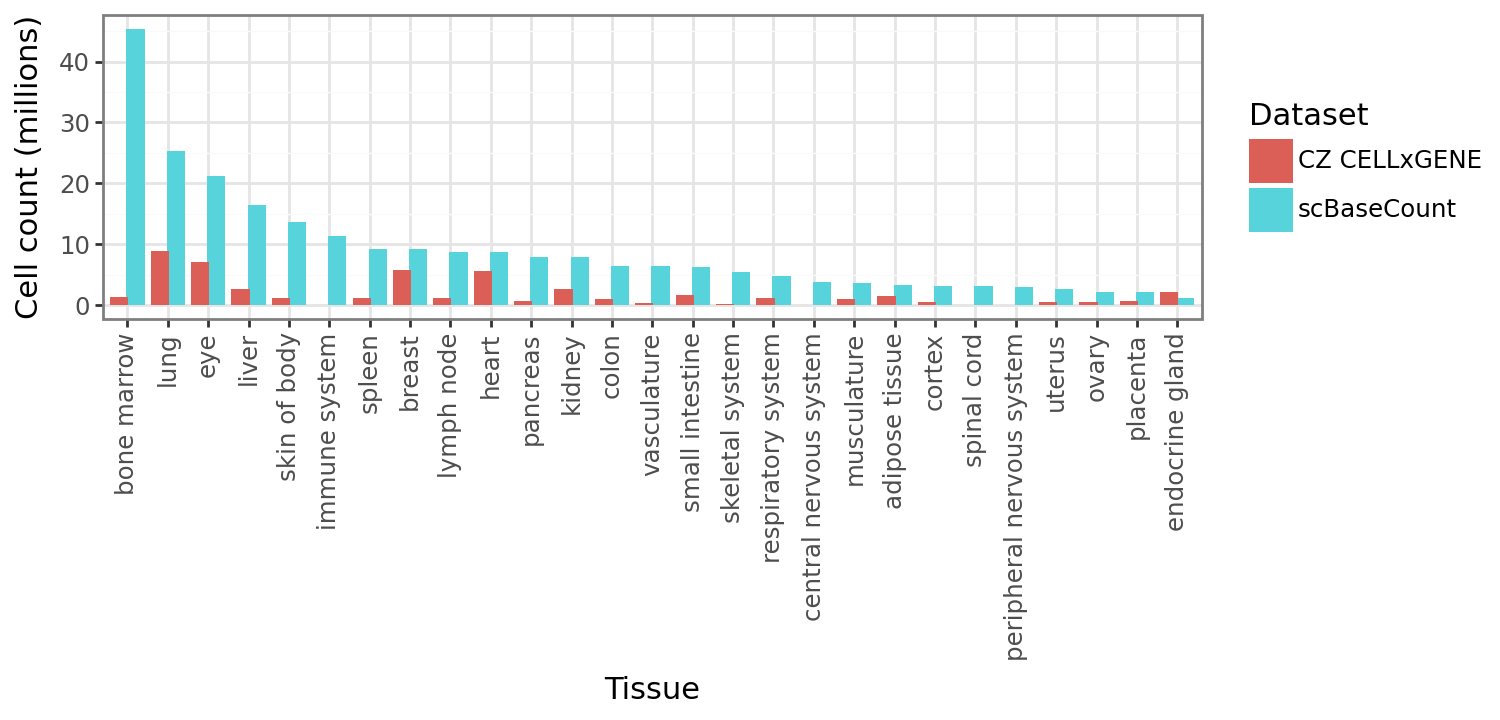

In [72]:
target_cols = ["brain", "blood", "embryo"]

## plot
p = (
    pn.ggplot(
        df_all_tissues_f[~df_all_tissues_f["tissue"].isin(target_cols)],
        pn.aes(x="tissue", y="cell_count", fill="dataset")
    ) + 
    pn.geom_col(position=pn.position_dodge(width=0.8)) +
    pn.labs(x="Tissue", y="Cell count (millions)", fill="Dataset") +
    pn.theme(
        figure_size=(7.5,3.6),
        axis_text_x=pn.element_text(angle=90, hjust=0.98)
    ))
p

In [73]:
# save as svg
outfile = base_dir / "figures" / "scBC-CxG_cells-by-tissue_other.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 7.5 x 3.6 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/scBC-CxG_cells-by-tissue_other.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/scBC-CxG_cells-by-tissue_other.svg


# By organism

In [74]:
# loading counts for non-human/mouse
czi_species_tissue = pd.read_csv(
    base_dir / "notebooks" / "tissues" / "data" / "czi_species_tissue.tsv", sep="\t"
).rename(columns={"count": "cell_count"})
czi_species_tissue["dataset"] = "CZ CELLxGENE"
czi_species_tissue

,organism,tissue,cell_count,dataset
0,Callithrix jacchus,Brodmann (1909) area 19,0,CZ CELLxGENE
1,Callithrix jacchus,Brodmann (1909) area 23,21148,CZ CELLxGENE
...,...,...,...,...
173,Sus scrofa,temporal lobe,0,CZ CELLxGENE
174,Sus scrofa,ventral lateral nucleus of thalamus,0,CZ CELLxGENE


In [75]:
# group by tissue and organism
cxg_data_tissues = (
    cxg_data.groupby(["tissue_general", "organism"])
    .agg({"cell_count": "sum"})
    .reset_index()
    .rename(columns={"tissue_general": "tissue"})
)
cxg_data_tissues["dataset"] = "CZ CELLxGENE"
cxg_data_tissues

,tissue,organism,cell_count,dataset
0,abdomen,Homo sapiens,414553,CZ CELLxGENE
1,adipose tissue,Homo sapiens,1075748,CZ CELLxGENE
...,...,...,...,...
101,vasculature,Mus musculus,2718,CZ CELLxGENE
102,yolk sac,Homo sapiens,169725,CZ CELLxGENE


In [76]:
# combine cxg_data_tissues and czi_species_tissue
cxg_data_tissues = pd.concat(
    [cxg_data_tissues, czi_species_tissue]
).groupby(["organism", "dataset"]).agg({"cell_count": "sum"}).reset_index()
cxg_data_tissues

,organism,dataset,cell_count
0,Callithrix jacchus,CZ CELLxGENE,629571
1,Gorilla gorilla,CZ CELLxGENE,139945
...,...,...,...
5,Pan troglodytes,CZ CELLxGENE,271028
6,Sus scrofa,CZ CELLxGENE,22056


In [77]:
# group by organism and sum cell counts
df_cells_sum = (
    df_cells
    .groupby("organism")
    .agg({"estimated_number_of_cells": "sum"})
    .reset_index()
    .rename(columns={"estimated_number_of_cells": "cell_count"})
)
df_cells_sum["dataset"] = "scBaseCount"
df_cells_sum

,organism,cell_count,dataset
0,Arabidopsis thaliana,1984986,scBaseCount
1,Bos taurus,1194485,scBaseCount
...,...,...,...
25,Taeniopygia guttata,5789,scBaseCount
26,Zea mays,279544,scBaseCount


In [78]:
# combine the datasets
df_all_organisms = pd.concat([df_cells_sum, cxg_data_tissues])
df_all_organisms

,organism,cell_count,dataset
0,Arabidopsis thaliana,1984986,scBaseCount
1,Bos taurus,1194485,scBaseCount
...,...,...,...
5,Pan troglodytes,271028,CZ CELLxGENE
6,Sus scrofa,22056,CZ CELLxGENE


In [79]:
# check the results
df_all_organisms.sort_values("cell_count", ascending=False)

,organism,cell_count,dataset
12,Homo sapiens,302619969,scBaseCount
16,Mus musculus,163895970,scBaseCount
...,...,...,...
10,Gorilla gorilla,9351,scBaseCount
25,Taeniopygia guttata,5789,scBaseCount


In [80]:
def pandas_complete(df: pd.DataFrame, 
                    group_cols: list, 
                   fill_cols: dict = None, 
                   fill_value: float = 0) -> pd.DataFrame:
    """
    Equivalent of tidyr::complete - fills missing combinations of grouping variables.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    group_cols : list
        List of column names to create combinations from
    fill_cols : dict, optional
        Dictionary mapping column names to fill values for missing combinations.
        If None, all non-grouping columns will be filled with fill_value
    fill_value : float, default 0
        Default value to fill missing combinations with
        
    Returns:
    --------
    pd.DataFrame
        Complete dataframe with all combinations and filled values
        
    Example:
    --------
    # Fill missing combinations with 0 for 'count' column
    df_complete = pandas_complete(df, 
                                 group_cols=['year', 'category'], 
                                 fill_cols={'count': 0})
    
    # Fill all non-grouping columns with 0
    df_complete = pandas_complete(df, group_cols=['year', 'category'])
    """
    import itertools
    
    # Get unique values for each grouping column
    unique_values = [df[col].unique() for col in group_cols]
    
    # Create all possible combinations
    all_combinations = list(itertools.product(*unique_values))
    df_complete = pd.DataFrame(all_combinations, columns=group_cols)
    
    # Merge with original data
    df_merged = df_complete.merge(df, on=group_cols, how='left')
    
    # Fill missing values
    if fill_cols is None:
        # Fill all non-grouping columns with fill_value
        non_group_cols = [col for col in df_merged.columns if col not in group_cols]
        fill_dict = {col: fill_value for col in non_group_cols}
    else:
        fill_dict = fill_cols
    
    df_result = df_merged.fillna(fill_dict)
    
    return df_result


In [81]:
# add zeros for missing combinations
df_all_organisms = pandas_complete(
    df_all_organisms,
    group_cols=["organism", "dataset"],
    fill_cols={"cell_count": 0}
)
df_all_organisms 

,organism,dataset,cell_count
0,Arabidopsis thaliana,scBaseCount,1984986.0
1,Arabidopsis thaliana,CZ CELLxGENE,0.0
...,...,...,...
52,Zea mays,scBaseCount,279544.0
53,Zea mays,CZ CELLxGENE,0.0


In [82]:
# format cell counts as millions
df_all_organisms["cell_count"] = df_all_organisms["cell_count"] / 1e6
df_all_organisms

,organism,dataset,cell_count
0,Arabidopsis thaliana,scBaseCount,1.984986
1,Arabidopsis thaliana,CZ CELLxGENE,0.000000
...,...,...,...
52,Zea mays,scBaseCount,0.279544
53,Zea mays,CZ CELLxGENE,0.000000


In [83]:
# set axis breaks
#breaks = [1e6, 7.9e6, 2.1e7, 4.1e7, 6.8e7, 1e8, 1.4e8, 1.85e8, 2.4e8, 3e8]

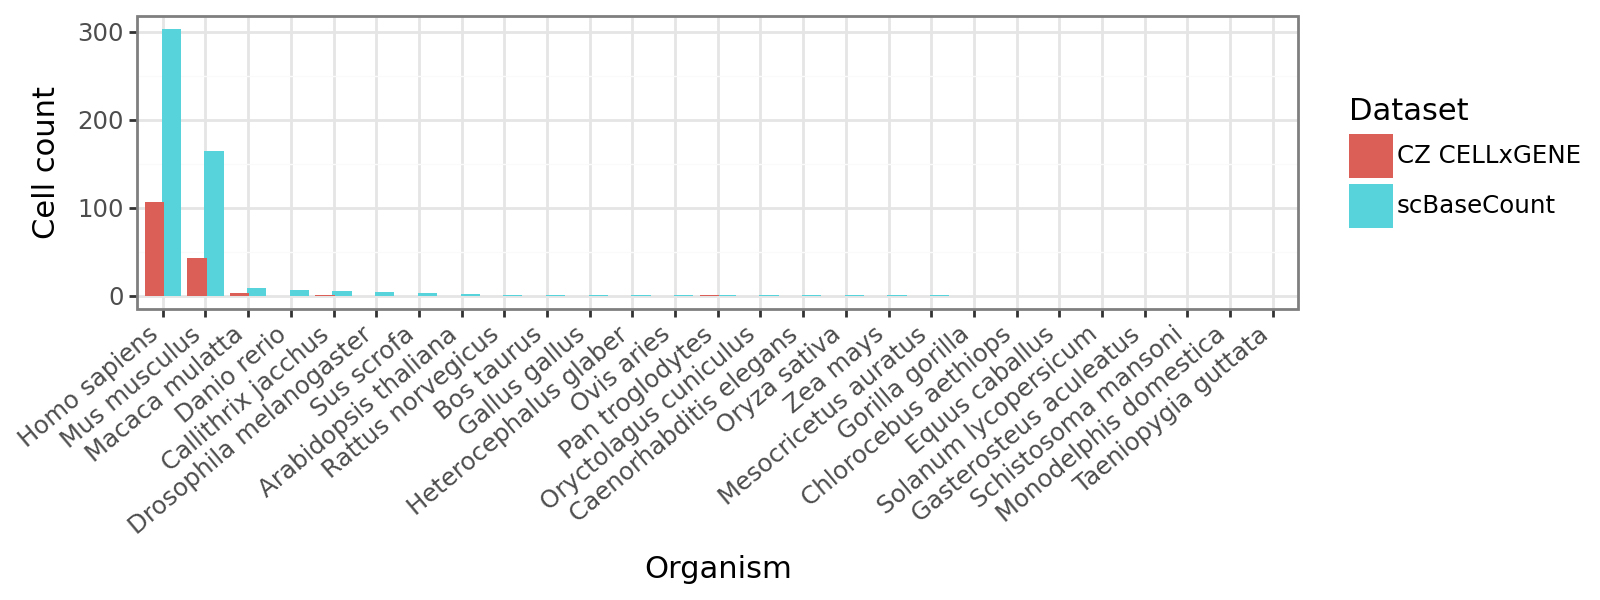

In [84]:
# plot

## sort organism by cell count
df_all_organisms['organism'] = pd.Categorical(
    df_all_organisms['organism'], 
    categories=df_all_organisms.sort_values('cell_count', ascending=False)['organism'].unique().tolist(), 
    ordered=True
)

## plot
p = (
    pn.ggplot(df_all_organisms, pn.aes(x="organism", y="cell_count", fill="dataset")) + 
    pn.geom_col(position=pn.position_dodge(width=0.8)) +
    pn.labs(x="Organism", y="Cell count", fill="Dataset") +
    pn.theme(
        figure_size=(8,3),
        axis_text_x=pn.element_text(angle=40, hjust=1)
    ))
p

/tmp/ipykernel_4146093/1116552225.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


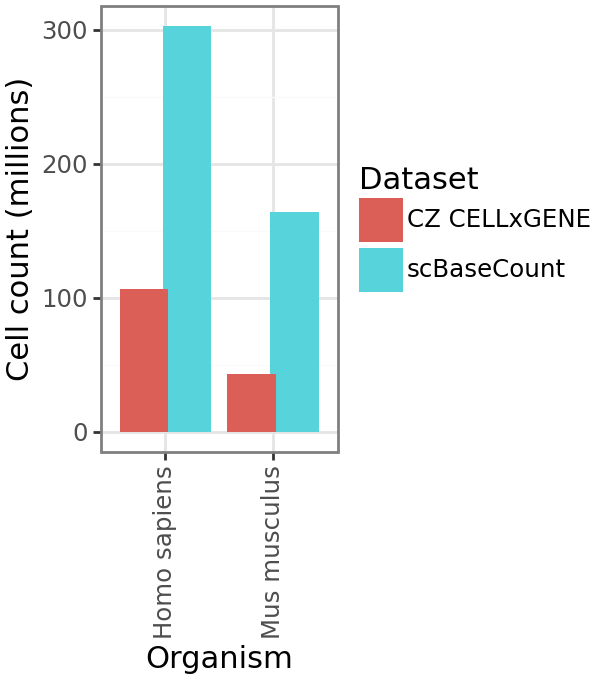

In [85]:
# plot

## just human/mouse
df_all_organisms_f = df_all_organisms[df_all_organisms["organism"].isin(["Homo sapiens", "Mus musculus"])]

## sort organism by cell count
df_all_organisms_f['organism'] = pd.Categorical(
    df_all_organisms_f['organism'], 
    categories=df_all_organisms_f.sort_values('cell_count', ascending=False)['organism'].unique().tolist(), 
    ordered=True
)

## plot
p = (
    pn.ggplot(df_all_organisms_f, pn.aes(x="organism", y="cell_count", fill="dataset")) + 
    pn.geom_col(position=pn.position_dodge(width=0.8)) +
    pn.labs(x="Organism", y="Cell count (millions)", fill="Dataset") +
    pn.theme(
        figure_size=(3,3.4),
        axis_text_x=pn.element_text(angle=90, hjust=0.98)
    ))
p

In [86]:
# save as svg
outfile = base_dir / "figures" / "scBC-CxG_cells-by-organism_hm.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/scBC-CxG_cells-by-organism_hm.svg


/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 3 x 3.4 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/scBC-CxG_cells-by-organism_hm.svg


/tmp/ipykernel_4146093/1344035962.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


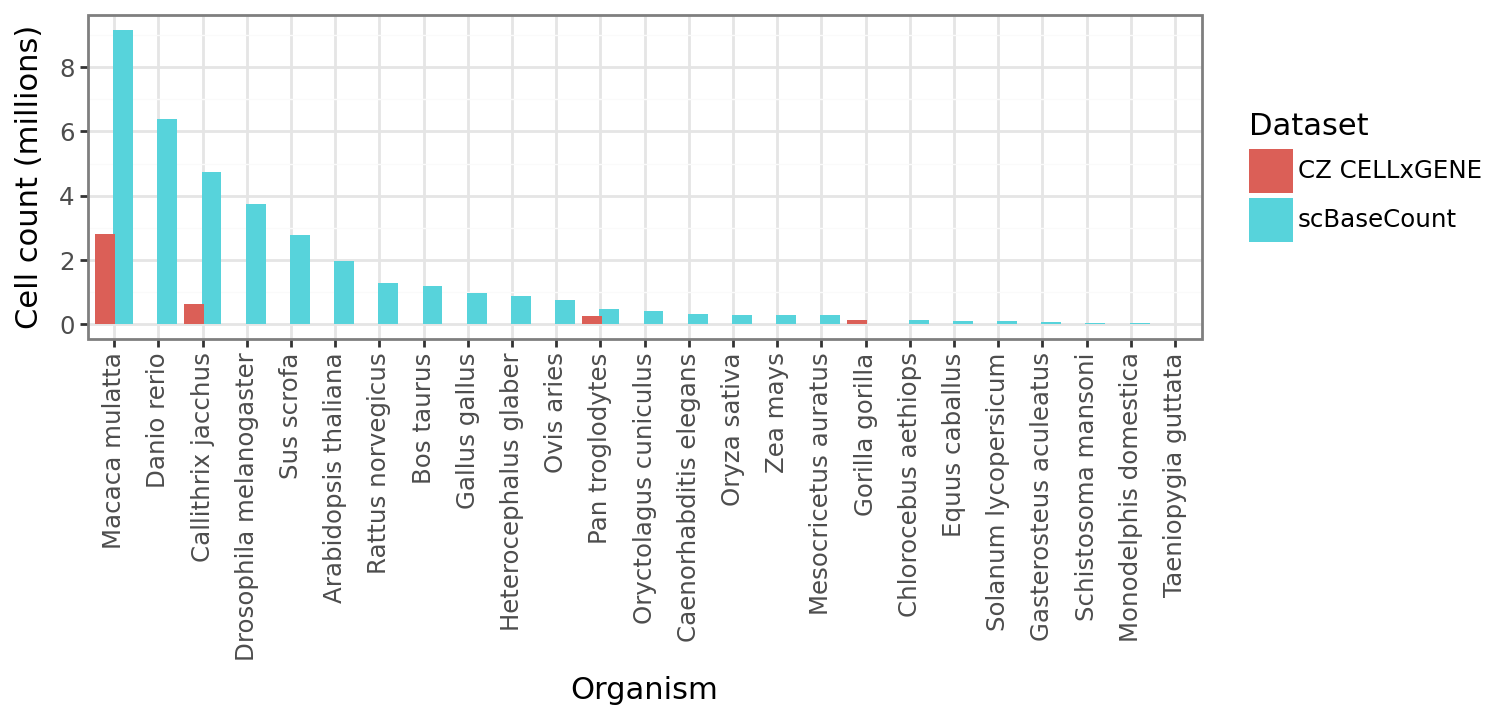

In [ ]:
# plot

## all except human/mouse
df_all_organisms_f = df_all_organisms[~df_all_organisms["organism"].isin(["Homo sapiens", "Mus musculus"])]

## sort organism by cell count
df_all_organisms_f['organism'] = pd.Categorical(
    df_all_organisms_f['organism'], 
    categories=df_all_organisms_f.sort_values('cell_count', ascending=False)['organism'].unique().tolist(), 
    ordered=True
)

## plot
p = (
    pn.ggplot(df_all_organisms_f, pn.aes(x="organism", y="cell_count", fill="dataset")) + 
    pn.geom_col(position=pn.position_dodge(width=0.8)) +
    pn.scale_y_continuous(breaks = range(0, 10, 2)) +
    pn.labs(x="Organism", y="Cell count (millions)", fill="Dataset") +
    pn.theme(
        figure_size=(7.5,3.6),
        axis_text_x=pn.element_text(angle=90, hjust=0.98)
    ))
p

In [88]:
# save as svg
outfile = base_dir / "figures" / "scBC-CxG_cells-by-organism_other.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/scBC-CxG_cells-by-organism_other.svg


/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 7.5 x 3.6 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/scBC-CxG_cells-by-organism_other.svg


# session info

In [89]:
!conda list

# packages in environment at /home/nickyoungblut/miniforge3/envs/SRAgent_nb:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
_python_abi3_support      1.0                  hd8ed1ab_2    conda-forge
aiobotocore               2.23.0             pyhd8ed1ab_0    conda-forge
aiohappyeyeballs          2.6.1              pyhd8ed1ab_0    conda-forge
aiohttp                   3.11.14                  pypi_0    pypi
aioitertools              0.12.0             pyhd8ed1ab_1    conda-forge
aiosignal                 1.3.2              pyhd8ed1ab_0    conda-forge
anndata                   0.11.4             pyhd8ed1ab_0    conda-forge
annotated-types           0.7.0                    pypi_0    pypi
anthropic                 0.57.1                   pypi_0    pypi
anyio                     4.9.0                    pypi_0    pypi
appdir